# Combine master files

## import modules

우선 필요한 모듈을 import합니다.

In [2]:
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.io import fits
import ysfitsutilpy as yfu

import _astro_utilities
import _Python_utilities

import warnings
warnings.filterwarnings('ignore')

## 프로젝트 폴더 

그리고 프로젝트 마다 폴더를 구분하여 저장하고 있으며, 프로젝트 폴더마다 전처리를 동일한 파일로 수행하는 방법을 택하고 있습니다. 
전처리 파일은 "CAL-BDF" 폴더에 모두 넣어두고 마스터 파일을 만들어서 사용합니다. 이때 폴더명/파일명은 pathlib을 이용하여 처리합니다.

In [3]:
#%%
verbose = False
tryagain = False
#######################################################
BASEDIR = Path("/mnt/Rdata/ASTRO_data")  

PROJECDIR = BASEDIR / "C1-Variable"
TODODIR = PROJECDIR / "-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
if verbose == True :
    print ("DOINGDIRs: ", format(DOINGDIRs))
    print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

try : 
    BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
    if verbose == True :
        print ("BDFDIR: ", format(BDFDIR))
    BDFDIR = Path(BDFDIR[0])    
except : 
    BDFDIR = TODODIR
    pass

DOINGDIRs = sorted([x for x in DOINGDIRs if "_LIGHT_" in str(x)])
if verbose == True :
    print ("DOINGDIRs: ", DOINGDIRs)
    print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

## summary 만들기

ysfitsutilpy는 fits 파일 다루기 매우 편리한 모듈이며 https://github.com/ysBach/ysfitsutilpy 에서 그 정보를 얻을 수 있습니다. 
yfu.summary 함수를 이용하여 fits file 의 summary dataframe을 만든다. 모든 bias, dark, flat 파일을 BDFDIR 폴더 안에 미리 복사해 두어야 합니다.

In [4]:

if verbose == True :
    # DOINGDIR = Path(BDFDIR[0])
    print(f"Starting: {str(BDFDIR.parts[-1])}")

MASTERDIR = BDFDIR / _astro_utilities.master_dir

summary = yfu.make_summary(BDFDIR/"*.fit*", 
                                verify_fix=True,
                                ignore_missing_simple=True,
                           )
if summary is not None :
    if verbose == True :
        #print(summary)
        print("len(summary):", len(summary))
        # print("summary:", summary)
        #print(summary["file"][0])

All 49 keywords (guessed from /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_BIAS_-_2017-01-02-22-03-32_0sec_-_STX-16803_-20c_2bin.fit) will be loaded.


``summary.columns`` 로 dataframe안에 있는 column을 확인할 수 있습니다.

In [5]:
# print("summary.columns :", summary.columns)

## BIAS

바이어스 오차(bias error)는 CCD 관측 각 픽셀 초기 값이 0 이 되어야 하는데, 실제로는 그렇지 않기 때문에 생기는 noise 입니다. 이 noise는 픽셀들의 기계적인 원인 때문에 발생하는 것이며 관측시 각 픽셀들은 몇 개의 전자를 가지고 관측을 시작하게 됩니다.
이러한 전자에 의해 생기는 noise는 bias image를 촬영하여 다음의 과정으로 보정할 수 있습니다.

* 광자가 모이기 힘들 정도의 최대한 짧은 exposure time으로 bais image를 가능한 한 여려 장(10 ~ 20 frame) 촬영 합니다.

* all bias image를 median 방법으로 combine 하여 얻은 master bias image를 "bias-median.fits"로 저장 합니다.

* bias image는 filter에 무관합니다.

* 다만 저장시에 data type에 유의해야 하는데, ccdproc로 저장한후 data type을 확인하는 것이 좋습니다.

master bias를 합성합니다.

In [6]:
if ( MASTERDIR / "master_bias.fits").exists() and tryagain == False :
    if verbose == True :
        print("The bias file is already exists, don't try again.")
else :
    summary_bias = summary.loc[summary["IMAGETYP"] == "BIAS"].copy()
    summary_bias.reset_index(inplace=True)
    if verbose == True :
        print("summary_bias", summary_bias)

    bias_fits = summary_bias["file"]
    if verbose == True :
        # print("type(bias_fits)", type(bias_fits))
        print("len(bias_fits)", len(bias_fits))
        # print("bias_fits", bias_fits)

    bias_comb = yfu.group_combine(
                    bias_fits.tolist(),
                    type_key = ["IMAGETYP"],
                    type_val = ["BIAS"],
                    group_key = ["EXPTIME"],
                    fmt = "master_bias.fits",  # output file name format
                    outdir = MASTERDIR,  # output directory (will automatically be made if not exist)
                    combine = "med",
                    memlimit = 2.e+10,
                    verbose = True,
                )

The bias file is already exists, don't try again.


### 화면에 디스플레이 해보기

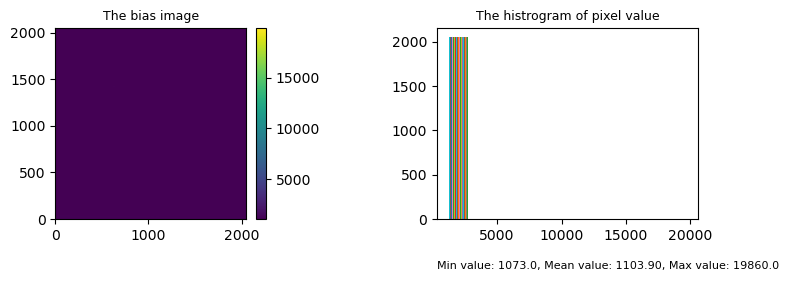

In [7]:
hdul = fits.open(MASTERDIR / "master_bias.fits")

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=None)

im1 = axs[0].imshow(hdul[0].data,
                origin='lower',
                )
im2 = axs[1].hist(hdul[0].data,
                )

axs[0].set_title('The bias image', fontsize=9)
axs[1].set_title('The histrogram of pixel value', fontsize=9)

plt.annotate(f"Min value: {hdul[0].data.min()}, Mean value: {hdul[0].data.mean():.02f}, Max value: {hdul[0].data.max()}", 
             xy=(0, -50), xycoords='axes pixels', fontsize=8)

plt.colorbar(im1, fraction=0.0455, pad=0.04)
plt.tight_layout(pad=5.0)

### 화면에 디스플레이 해보기

* zimshow를 이용해 보자.
* 히스토그램 출력 범위 변경

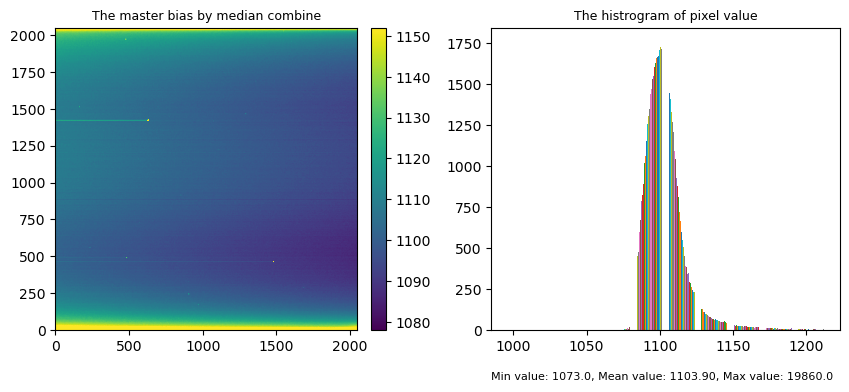

In [8]:
hdul = fits.open(MASTERDIR / "master_bias.fits")

fig, axs = plt.subplots(1, 2, figsize=(9, 4),
                        sharex=False, sharey=False, gridspec_kw=None)

im1 = _astro_utilities.zimshow(axs[0],
            hdul[0].data,
            cmap='viridis',
            origin='lower',)

im2 = axs[1].hist(hdul[0].data,
                  range=(hdul[0].data.mean()*.9, hdul[0].data.mean()*1.1),
                  )

axs[0].set_title(f'The master bias by median combine', fontsize=9)
axs[1].set_title('The histrogram of pixel value', fontsize=9)

plt.colorbar(im1, fraction=0.0455, pad=0.04)
plt.annotate(f"Min value: {hdul[0].data.min()}, Mean value: {hdul[0].data.mean():.02f}, Max value: {hdul[0].data.max()}",
             xy=(0, -50), xycoords='axes pixels', fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

## DARK

암전류(dark current)는 CCD가 빛을 받지 않더라도 실리콘 격자의 열진동에 의하여 pixel에서 만들어진 신호를 말하며 이를 열화 노이즈라고 합니다. 즉, 실리콘 격자의 온도가 높으면 가전자의 일부가 튀어나오게 되는데 이러한 전자들이 신호를 만들게 됩니다. 이러한 암전류는 온도가 높을수록, 그리고 exposure time에 비례하게 나타납니다.

CCD를 냉각하여 dark current를 줄여줄 수 있으나, 완전히 제거할 수는 없으므로 dark frame을 촬영하여 이를 제거해 줍니다. dark current는 시간의 linear function 이므로 dark image의 exposure time을 $t$ second라 한다면 $dark(t)$는 다음과 같이 구할 수 있습니다.
$$ {\displaystyle{dark(1) = \frac{dark0(t) - bias}{t}}}$$

대상 이미지의 노출 시간이 $t$인 경우 $dark(1)$에 $t$를 곱한 다음 'master dark'로 사용하면 dark frame을 촬영하는 시간을 절약할 수 있습니다. 다만 이 경우
dark current가 노출 시간에 정확하게 비례한다는 가정하에 수행하는 것입니다. 따라서 일반적으로 그러나 dark frmae은 대상을 촬영한 것과 exposeure time을 같게 하여 촬영하는 것이 일반적입니다.

이러한 noise를 dark current noise라고 하며 dark frame을 촬영하여 다음의 과정으로 보정을 합니다.

* 셔터를 닫은 상태에서 calibration을 수행할 light frame과 같은 온도, 같은 exposure time으로 dark image를 가능한 한 여려 장(10 ~ 20 frame) 촬영한다.
* all dark image를 median 방법으로 combine 한 후 "dark0-median.fits"로 저장한다.
* dark0 값에서 master bias를 빼준다.
* save it as "dark-median.fits"
* dark image는 filter에 무관하다.
* 다만 저장시에 data type에 유의해야 하는데, ccdproc로 저장한후 data type을 확인하는 것이 좋다.


master dark 합성시에 group_key 값을 ["EXPTIME"] 으로 해주면 같은 노출 시간 끼리 합성할 수 있습니다.

In [9]:
summary_dark = summary.loc[summary["IMAGETYP"] == "DARK"].copy()
summary_dark.reset_index(inplace=True)
if verbose == True :
    print("summary_dark", summary_dark)

if 'EXPTIME' in summary_dark :
    check_exptimes = summary_dark['EXPTIME'].drop_duplicates()
    check_exptimes = check_exptimes.reset_index(drop=True)
    if verbose == True :
        print("check_exptimes", check_exptimes)

    for exptime in check_exptimes :
        if (MASTERDIR / f"master_dark_{exptime:.0f}sec.fits" ).exists() and tryagain == False :
            if verbose == True :
                print(f"master_dark_{exptime:.0f}sec.fits already exist....")
        else :
            summary_dark_each = summary_dark.loc[summary_dark['EXPTIME'] == exptime]
            dark_fits = summary_dark_each['file']
            if verbose == True :
                # print("type(dark_fits)", type(dark_fits))
                print("len(dark_fits)", len(dark_fits))
                # print("dark_fits", dark_fits)

            dark_comb = yfu.group_combine(
                        dark_fits.tolist(),
                        type_key = ["IMAGETYP"],
                        type_val = ["DARK"],
                        group_key = ["EXPTIME"],
                        fmt = "master_dark_{:.0f}sec.fits",  # output file name format
                        outdir = MASTERDIR,  # output directory (will automatically be made if not exist)
                        combine = "med",
                        memlimit = 2.e+10,
                        verbose = True,
                    )

master dark 파일의 목록을 확인해 보겠습니다. 

In [10]:
dark_fpaths = sorted(list((MASTERDIR).glob('*dark*.fit*')))
if verbose == True : 
    print(f"dark_fpaths: {dark_fpaths}")
    print(f"len(dark_fpaths): {len(dark_fpaths)}")

dark_fpaths: [PosixPath('/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2017-01_-_RiLA600_STX-16803_-_2bin/master_files_ys/master_dark_100sec.fits'), PosixPath('/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2017-01_-_RiLA600_STX-16803_-_2bin/master_files_ys/master_dark_120sec.fits')]
len(dark_fpaths): 2


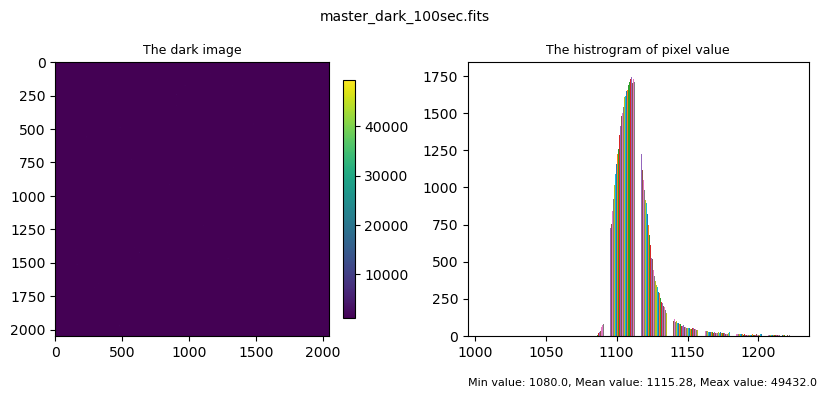

In [ ]:
fpath = Path(dark_fpaths[0])
hdul = fits.open(fpath)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=None)

im1 = axs[0].imshow(hdul[0].data)
im2 = axs[1].hist(hdul[0].data, 
                range=(hdul[0].data.mean()*.9, hdul[0].data.mean()*1.1),
                    )

axs[0].set_title('The dark image', fontsize=9)
axs[1].set_title('The histrogram of pixel value', fontsize=9)

plt.annotate(f"Min value: {hdul[0].data.min()}, Mean value: {hdul[0].data.mean():.02f}, Meax value: {hdul[0].data.max()}", 
             xy=(0, -50), xycoords='axes pixels', fontsize=8)

plt.colorbar(im1, fraction=0.035, pad=0.04)
fig.suptitle(f"{fpath.name}", fontsize=10) 
plt.tight_layout(pad=1.0)

## Flat

다음으로 생각해 보아야 할 것은 픽셀들 간의 양자 효율에 대해서 생각해 보아야 합니다. 다시 말해 를 이루고 있는 픽셀들이 똑같은 빛에 대해서 똑같은 비율로 반응하는가 하는 점에 대해 생각해 볼 필요가 있습니다. 또한 광학계의 vignetting이나, filter 앞의 먼지 등으로 같은 밝기가 같은 픽셀 값을 나타내지 않을 수 있습니다.

이 error는 다음과 같이 flat frame을 촬영하여 보정할 수 있습니다. flat frame을 촬영하여 bias와 dark를 제거하여 master flat을 만드는 과정은 다음과 같습니다.

* 해 질 무렵 동쪽 하늘이나 해 뜰 무렵 서쪽하늘을 이 flat 한 하늘로 볼 수 있습니다. $ADU$ 값이 25,000 전후가 되도록 flat image를 가능한 한 여려 장(10 ~ 20 frame) 촬영합니다.
* 필터를 사용할 경우 각각의 필터 마다 flat frame을 촬영해야 합니다.
* all flat image를 median 방법으로 combine "flat0-median.fits"로 저장합니다.
* flat0 값에서 bias 와 dark (dark should be scaled)
* save it as "flat.fits"
* save it as "flat-median.fits"

* 다만 저장시에 data type에 유의해야 하는데, ccdproc로 저장한후 data type을 확인해야 할 필요가 있습니다.

flat image에는 spatial variation이 있기 때문에 rejected pixel values 들을 모든 픽셀의 median value로 대체 할 수 없습니다. 보통은 lower limit of pixel value (`min_value`)를 설정하고 이 값보다 작은 픽셀 값을 바꾸는 것이 일반적인 방법입니다. 'min_value '보다 작은 픽셀을 'min_value'로 변경하겠습니다.

앞서 언급했지만 dark frame은 노출시간에 맞게 `dark(t)/t * t'` 의 방법으로 "scaled" 되어야 합니다. 이 과정은 `ccd_process` fucntion 의 "`dark_scale`" 에서 자동 조정됩니다.

Master flat 합성시에 group_key 값을 ["FILTER"] 로 해주면 같은 필터 끼리 합성할 수 있습니다.

In [16]:
summary_flat = summary.loc[summary["IMAGETYP"] == "FLAT"].copy()
summary_flat.reset_index(inplace=True)

if 'FILTER' in summary_flat :
    check_filters = summary_flat['FILTER'].drop_duplicates()
    check_filters = check_filters.reset_index(drop=True)
    if verbose == True :
        print("check_filters", check_filters)

    for filter in check_filters :
        if (MASTERDIR / f"master_flat_{filter:s}_norm.fits" ).exists() and tryagain == False :
            if verbose == True :
                print(f"master_flat_{filter:s}_norm.fits already exist....")
        else : 
            summary_flat_each = summary_flat.loc[summary_flat['FILTER'] == filter]
            flat_fits = summary_flat_each['file']
            if verbose == True :
                # print("type(flat_fits)", type(flat_fits))
                print("len(flat_fits)", len(flat_fits))
                # print("flat_fits", flat_fits)

            try : 
                flat_comb= yfu.group_combine(
                                flat_fits.tolist(),
                                type_key = ["IMAGETYP"],
                                type_val = ["FLAT"],
                                group_key = ["FILTER"],
                                fmt = "master_flat_{:s}.fits",  # output file name format
                                scale="med_sc", #norm
                                scale_to_0th=False, #norm
                                outdir = MASTERDIR,  # output directory (will automatically be made if not exist)
                                combine = "med",
                                memlimit = 2.e+10,
                                verbose=verbose,
                            )
            except : 
                flat_comb = yfu.group_combine(
                            flat_fits.tolist(),
                            type_key = ["IMAGETYP"],
                            type_val = ["FLAT"],
                            group_key = ["FILTER"],
                            fmt = "master_flat_{:s}.fits",  # output file name format
                            #scale="med_sc", #norm
                            #scale_to_0th=False, #norm
                            outdir = MASTERDIR,  # output directory (will automatically be made if not exist)
                            combine = "med",
                            memlimit = 2.e+10,
                            verbose=verbose,
                        )

## Flat image

Master flat image 경로를 확인해 보겠습니다.

In [17]:
flat_fpaths = sorted(list((MASTERDIR).glob('*flat*.fit*')))
if verbose == True : 
    print(f"flat_fpaths: {dark_fpaths}")
    print(f"len(flat_fpaths): {len(flat_fpaths)}")

flat_fpaths: [PosixPath('/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2017-01_-_RiLA600_STX-16803_-_2bin/master_files_ys/master_dark_100sec.fits'), PosixPath('/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2017-01_-_RiLA600_STX-16803_-_2bin/master_files_ys/master_dark_120sec.fits')]
len(flat_fpaths): 6


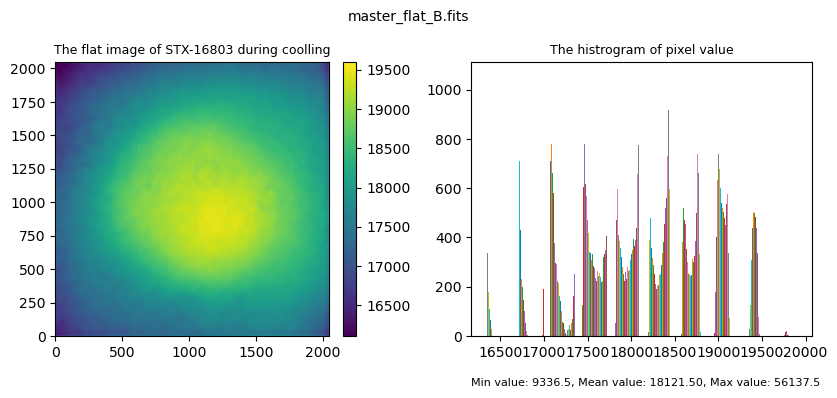

In [19]:
fpath = Path(flat_fpaths[0])
hdul = fits.open(fpath)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=None)

im1 = _astro_utilities.zimshow(axs[0], 
                               hdul[0].data)
im2 = axs[1].hist(hdul[0].data ,
                  range=(hdul[0].data.mean()*.9, hdul[0].data.mean()*1.1),
                    )

axs[0].set_title('The flat image of STX-16803 during coolling', fontsize=9)
axs[1].set_title('The histrogram of pixel value', fontsize=9)

plt.annotate(f"Min value: {hdul[0].data.min()}, Mean value: {hdul[0].data.mean():.02f}, Max value: {hdul[0].data.max()}", 
             xy=(0, -50), xycoords='axes pixels', fontsize=8)

plt.colorbar(im1, fraction=0.0455, pad=0.04)
fig.suptitle(f"{fpath.name}", fontsize=10) 
plt.tight_layout(pad=1.0)